# Symbolic regression for feature engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from gplearn.genetic import SymbolicTransformer
from xgboost import XGBRegressor

from sklearn.metrics import r2_score as r2

In case there's a strong physical relation between the features and the target, symbolic regression can serve us as a powerful tool to derive it. As a demonstration, we'll generate a dataset of 20000 entries with three random features, and use the simple inverse square law to generate tagets. We'll also add a bit of random jitter to the target:

In [2]:
random_state = 177013

In [3]:
rng = np.random.default_rng(random_state)
X = rng.integers(low=1, high=10, size=60000).reshape(20000,3)
noise = rng.integers(low=-10, high=10, size=20000) / 10.0
y = 5. * X[:, 0] * 3. * X[:, 1] / X[:, 2] ** 2 + noise

Next, we'll separate a test set of 2000 entries:

In [4]:
train_X, test_X = X[:18000], X[18000:]
train_y, test_y = y[:18000], y[18000:]

Linear models won't be able to approximate the law too well:

In [5]:
lr = LinearRegression()
lr.fit(train_X, train_y)
p = lr.predict(test_X)

In [6]:
r2(test_y,p)

0.3810508443460642

Evidently, that's just around 38% explained variance. That's still much better than a mean value prediction:

In [7]:
dr = DummyRegressor()
dr.fit(train_X, train_y)
dr.score(test_X, test_y)

-0.0010827454932265113

As the simplified chart pictures, the prediction quality diminishes quickly as the quadratic law kicks in:

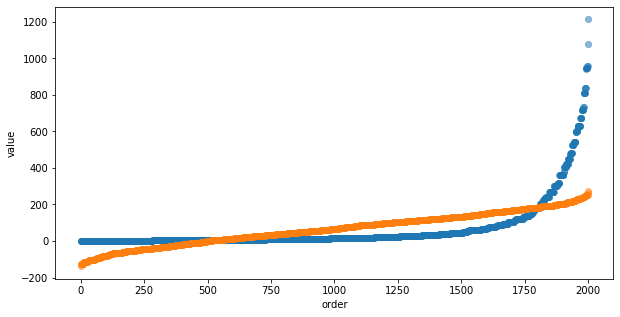

In [8]:
x = np.linspace(0, 2000, 2000)
plt.figure(figsize=(10,5))
plt.scatter(x, sorted(test_y), alpha=0.5);
plt.scatter(x, sorted(p), alpha=0.5);
plt.xlabel('order');
plt.ylabel('value');

Gplearn *SymbolicTransformer()* (sklearn-compatible), however, quickly catches on the correct figure:

In [9]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min']
st = SymbolicTransformer(n_components=1, function_set=function_set, verbose=1, n_jobs=-1, random_state=random_state)
new = st.fit_transform(train_X, train_y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.73         0.274481       11         0.940718              N/A     30.63s
   1    12.06         0.522573       11         0.999992              N/A     13.06s
   2    14.25         0.598919       11         0.999992              N/A     13.78s
   3    15.24         0.746429       11         0.999992              N/A     12.40s
   4    12.97         0.788606       11         0.999992              N/A     11.24s
   5     9.61         0.807805       10         0.999992              N/A     10.24s
   6     7.58         0.838227       11         0.999992              N/A      8.95s
   7     7.07         0.825114        7         0.999992              N/A      8.19s
   8     6.93         0.849058        7         0.999992              N/A  

In most cases, it is able to represent it in a (X1/X2)\*(X0/X2) or (X0/X2)/(X2/X1) form:

mul(div(X1, X2), div(X0, X2))


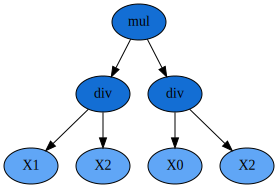

In [10]:
print(st._best_programs[0])
# Comment out the following if you haven't got Graphviz installed:
dot_data = st._best_programs[0].export_graphviz()
graph = graphviz.Source(dot_data)
graph

While in the simplest cases like this we can just as well use *SymbolicRegressor()*, using generated feature for the linear regression works just as well:

In [11]:
new_train = np.hstack([train_X, new[:,0].reshape(18000,1)])
new_test = st.transform(test_X)

In [12]:
test_X_new = np.hstack([test_X, new_test[:,0].reshape(2000,1)])

In [13]:
lr.fit (new_train, train_y)
p = lr.predict(test_X_new)

In [14]:
r2(test_y,p)

0.9999837975048632

This time, the prediction is industrial quality: explained variance is just around 2e-5 short of perfection, provided with the noise generated - no wonder, since the newly generated feature has a perfectly linear correlation with the target.

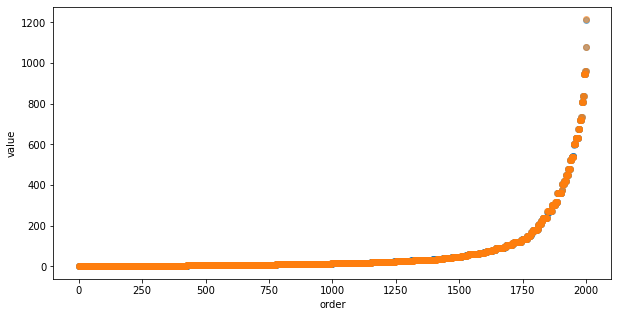

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(x, sorted(test_y), alpha=0.5);
plt.scatter(x, sorted(p), alpha=0.5);
plt.xlabel('order');
plt.ylabel('value');

This is on par, or even slightly better than untuned XGBoost results:

In [16]:
xgb = XGBRegressor(n_jobs=-1, random_state=random_state)
xgb.fit(train_X, train_y)
p2 = xgb.predict(test_X)

In [17]:
r2(test_y,p2)

0.999979916535485